<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Prepare data

In [2]:
import numpy as np
import pandas as pd

task = 2
# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task}/train{task}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task-1}/benchmark{'0' + str(task-1) if task-1 < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)[:'2013-05-01 00:00']

In [3]:
for i in range(1, 4):
    predictor_data[f'SURFACE SOLAR RADIATION {i}'] /= predictor_data[f'SURFACE SOLAR RADIATION {i}'].max()
    predictor_data[f'SURFACE THERMAL RADIATION {i}'] /= predictor_data[f'SURFACE THERMAL RADIATION {i}'].max()
    predictor_data[f'TOP NET SOLAR RADIATION {i}'] /= predictor_data[f'TOP NET SOLAR RADIATION {i}'].max()

In [4]:
predictor1 = predictor_data[['SURFACE SOLAR RADIATION 1', 'SURFACE THERMAL RADIATION 1', 'TOP NET SOLAR RADIATION 1']]

train_data1 = train_data[['ZONEID 1']]

In [5]:
x_input_df = predictor1
x_input = np.array(x_input_df)
y_output = np.array(train_data1)

In [6]:
var_weights = np.var(x_input, axis=0)
x_input = var_weights ** (-1) * x_input

In [7]:
from sklearn.neighbors import NearestNeighbors

minkowski_dist = 2
x_neighbors = NearestNeighbors(n_neighbors=50, algorithm='auto', p=minkowski_dist).fit(x_input)
dist, indx = x_neighbors.kneighbors(x_input)

In [8]:
y_neighbors = y_output[indx[0, :]].T
for i in range(1, np.size(indx, 0)):
    values_to_add = y_output[indx[i, :]].T
    y_neighbors = np.vstack([y_neighbors, values_to_add])

In [9]:
yq_output = np.quantile(y_neighbors, q=[p / 100 for p in range(1, 100)], axis=1).T
yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
    .rename(columns={p: str((p+1)/100) for p in range(99)})
yq_output_df

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2012-04-01 01:00:00,0.325074,0.486365,0.505211,0.517995,0.532077,0.546274,0.562346,0.578679,0.601452,0.625481,...,0.843763,0.844925,0.845933,0.846153,0.847300,0.855090,0.863836,0.883342,0.902090,0.903032
2012-04-01 02:00:00,0.085936,0.099756,0.192001,0.287582,0.366721,0.444399,0.471193,0.490887,0.495180,0.496468,...,0.818878,0.819978,0.821333,0.824003,0.826685,0.829449,0.832503,0.838816,0.846142,0.877270
2012-04-01 03:00:00,0.170024,0.340047,0.347258,0.347541,0.359651,0.372812,0.383188,0.393177,0.395649,0.396654,...,0.758160,0.758569,0.758915,0.758947,0.759597,0.764686,0.770987,0.790933,0.810664,0.825364
2012-04-01 04:00:00,0.071335,0.142542,0.156928,0.168895,0.184785,0.201024,0.204336,0.205844,0.206668,0.207359,...,0.617340,0.618125,0.619479,0.623751,0.634573,0.692337,0.745510,0.747049,0.748669,0.752187
2012-04-01 05:00:00,0.026924,0.030003,0.034708,0.039482,0.040679,0.041559,0.042687,0.043849,0.044564,0.045192,...,0.532192,0.543249,0.552531,0.552719,0.553038,0.554295,0.558800,0.599853,0.639619,0.649137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-04-30 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250147,0.423626,0.569797,0.576017,0.582482,0.590712,0.598279,0.598405,0.599101,0.613204
2013-04-30 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.542821,0.556955,0.569797,0.576017,0.582497,0.590853,0.600308,0.622138,0.646018,0.718073
2013-04-30 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000263,0.000577,...,0.581615,0.582306,0.584136,0.591800,0.599837,0.610548,0.621292,0.632412,0.646018,0.718073


# Train the linear regression model (ANN10)

## Prepare data for regression model

In [10]:
import pandas as pd
from sklearn import preprocessing

# normalize predictor values
x = predictor1.values
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(x)
predictor1 = pd.DataFrame(scaled)
predictor1

,0,1,2
0,0.070457,0.010104,0.057922
1,0.152360,0.047458,0.142628
2,0.227996,0.084522,0.224650
3,0.285150,0.121753,0.290287
4,0.322960,0.161768,0.338952
...,...,...,...
9475,0.220287,0.683490,0.256298
9476,0.220471,0.720201,0.256733
9477,0.226896,0.758322,0.267201
9478,0.244268,0.796864,0.291180


In [11]:
h = 24
h1 = 24

data = predictor1
x_pieces = []
for i in range(h1):
    piece = data.drop(range(i)).reset_index().drop('index', axis=1)
    x_pieces.insert(0, piece)

x = pd.concat(x_pieces, axis=1)
x.index = x.index.map(lambda x: x + h1 - 1)
x = x[:-h+1]
x

,0,1,2,0,1,2,0,1,2,0,...,2,0,1,2,0,1,2,0,1,2
23,0.450364,0.837689,0.506044,0.406165,0.796552,0.454506,0.376154,0.758559,0.417812,0.360530,...,0.290287,0.227996,0.084522,0.224650,0.152360,0.047458,0.142628,0.070457,0.010104,0.057922
24,0.045105,0.013434,0.039247,0.450364,0.837689,0.506044,0.406165,0.796552,0.454506,0.376154,...,0.338952,0.285150,0.121753,0.290287,0.227996,0.084522,0.224650,0.152360,0.047458,0.142628
25,0.092515,0.053876,0.098001,0.045105,0.013434,0.039247,0.450364,0.837689,0.506044,0.406165,...,0.368936,0.322960,0.161768,0.338952,0.285150,0.121753,0.290287,0.227996,0.084522,0.224650
26,0.145630,0.095325,0.160508,0.092515,0.053876,0.098001,0.045105,0.013434,0.039247,0.450364,...,0.388876,0.342790,0.200918,0.368936,0.322960,0.161768,0.338952,0.285150,0.121753,0.290287
27,0.198880,0.135820,0.222171,0.145630,0.095325,0.160508,0.092515,0.053876,0.098001,0.045105,...,0.394023,0.356316,0.238150,0.388876,0.342790,0.200918,0.368936,0.322960,0.161768,0.338952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9475,0.220287,0.683490,0.256298,0.220287,0.646925,0.256298,0.220287,0.613121,0.256298,0.220287,...,0.387337,0.329628,0.833101,0.358668,0.309107,0.795727,0.332274,0.305069,0.757640,0.324127
9476,0.220471,0.720201,0.256733,0.220287,0.683490,0.256298,0.220287,0.646925,0.256298,0.220287,...,0.017545,0.349089,0.872224,0.387337,0.329628,0.833101,0.358668,0.309107,0.795727,0.332274
9477,0.226896,0.758322,0.267201,0.220471,0.720201,0.256733,0.220287,0.683490,0.256298,0.220287,...,0.063724,0.020428,0.014910,0.017545,0.349089,0.872224,0.387337,0.329628,0.833101,0.358668
9478,0.244268,0.796864,0.291180,0.226896,0.758322,0.267201,0.220471,0.720201,0.256733,0.220287,...,0.119693,0.056263,0.054627,0.063724,0.020428,0.014910,0.017545,0.349089,0.872224,0.387337


In [12]:
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

prediction = pd.DataFrame()

for p in tqdm(range(1, 100)):
    y = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
    model = MLPRegressor(hidden_layer_sizes=(6,))

    trained = model.fit(x[:-24*30], y[:-24*30])
    prediction.insert(p-1, str(p/100), trained.predict(x[-24*30:]))

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


# Postprocessing: Remove quantile crossing

In [13]:
prediction['0.01'] = np.maximum(prediction['0.01'], 0)
for p in range(2, 100):
    prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])
prediction

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.039472,0.213464,0.213464,0.314828,0.314828,0.314828,0.369159,0.369159,0.369159,0.369159,...,0.830405,0.877744,0.877744,0.877744,0.878192,0.878192,0.878192,0.878317,0.879628,0.879628
1,0.039472,0.318768,0.318768,0.329714,0.330970,0.360868,0.422526,0.422526,0.422526,0.422526,...,0.849395,0.865738,0.890829,0.890829,0.890829,0.890829,0.890829,0.901858,0.932682,0.932682
2,0.039472,0.274078,0.274078,0.303150,0.303150,0.303150,0.359803,0.359803,0.359803,0.359803,...,0.796102,0.880579,0.880579,0.880579,0.880579,0.880579,0.880579,0.880579,0.880579,0.880579
3,0.039472,0.180408,0.180408,0.251216,0.251216,0.251216,0.257198,0.257198,0.277190,0.335926,...,0.741303,0.741303,0.763256,0.763256,0.763256,0.763256,0.763256,0.763256,0.763256,0.783332
4,0.039472,0.039472,0.059473,0.133923,0.133923,0.133923,0.171863,0.171863,0.171863,0.171863,...,0.598378,0.635252,0.635252,0.635252,0.635252,0.641245,0.641245,0.641245,0.678702,0.686172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.039472,0.039472,0.039472,0.039472,0.039472,0.039472,0.039472,0.039472,0.039472,0.039472,...,0.288457,0.288457,0.288457,0.288457,0.288457,0.288457,0.296748,0.325723,0.351381,0.358618
716,0.039472,0.039922,0.039922,0.039922,0.039922,0.039922,0.039922,0.039922,0.039922,0.039922,...,0.312902,0.332049,0.332049,0.332049,0.332049,0.332049,0.380685,0.436874,0.466378,0.466378
717,0.039472,0.094587,0.094587,0.094587,0.094587,0.094587,0.094587,0.094587,0.094587,0.094587,...,0.429080,0.429080,0.429080,0.429080,0.429080,0.468499,0.512519,0.611504,0.611504,0.611504
718,0.039472,0.077169,0.077169,0.077169,0.077169,0.077169,0.077169,0.077169,0.077169,0.077169,...,0.516594,0.519295,0.519295,0.519295,0.571845,0.571845,0.597332,0.652293,0.748072,0.748072


# Plotting the quantile prediction for the first entries

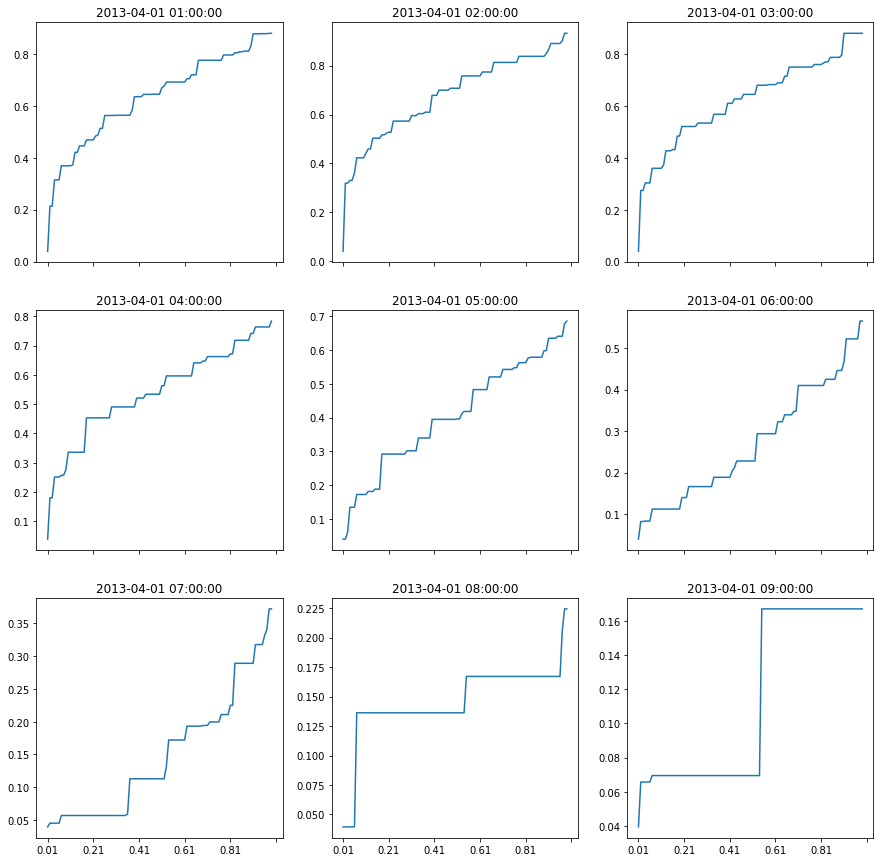

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [15]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [16]:
test_ts = np.squeeze(train_data1['2013-04-01 01:00':].values)
loss = np.mean(pinnball_loss(test_ts, yq_output_df['2013-04-01 01:00':]))

print(f"Loss of task {task} only nearest neighbors: {round(loss, 5)}")

Loss of task 2 only nearest neighbors: 0.02368


In [17]:
loss = np.mean(pinnball_loss(test_ts, prediction))

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 2 with NNQF: 0.04378
